ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [7]:
X_train.shape

(52500, 12)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [16]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [17]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [25]:
classifier_log = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C = 0.10,random_state = 42)),
])

classifier_random_forest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=20, max_depth=5, random_state = 42)),
])

classifier_lightgbm = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state = 42)),
])

#запустим кросс-валидацию для логистической регрессии
cv_scores_log = cross_val_score(classifier_log, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_log = np.mean(cv_scores_log)
cv_score_std_log = np.std(cv_scores_log)
print('CV_log score is {}+-{}'.format(cv_score_log, cv_score_std_log))

#обучим пайплайн на всем тренировочном датасете
classifier_log.fit(X_train, y_train)
y_score_log = classifier_log.predict_proba(X_test)[:, 1]


#запустим кросс-валидацию для случайного леса
cv_scores_random_forest = cross_val_score(classifier_random_forest,\
                                          X_train, y_train, cv=4, scoring='roc_auc')
cv_score_random_forest = np.mean(cv_scores_random_forest)
cv_score_std_random_forest = np.std(cv_scores_random_forest)
print('CV_random_forest score is {}+-{}'.format(cv_score_random_forest,\
                                                cv_score_std_random_forest))

#обучим пайплайн на всем тренировочном датасете
classifier_random_forest.fit(X_train, y_train)
y_score_random_forest = classifier_random_forest.predict_proba(X_test)[:, 1]


#запустим кросс-валидацию для бустинга lightgbm
cv_scores_lightgbm = cross_val_score(classifier_lightgbm,\
                                          X_train, y_train, cv=4, scoring='roc_auc')
cv_score_lightgbm = np.mean(cv_scores_lightgbm)
cv_score_std_lightgbm = np.std(cv_scores_lightgbm)
print('CV_lightgbm score is {}+-{}'.format(cv_score_lightgbm,\
                                                cv_score_std_lightgbm))

#обучим пайплайн на всем тренировочном датасете
classifier_lightgbm.fit(X_train, y_train)
y_score_lightgbm = classifier_lightgbm.predict_proba(X_test)[:, 1]

CV_log score is 0.7840550385416074+-0.0021645556767291986
CV_random_forest score is 0.7940468343242751+-0.0025001417090835002
CV_lightgbm score is 0.8015205599234987+-0.0027543576287143924


Посчитаем precision/recall/f_score

In [45]:
from sklearn.metrics import precision_recall_curve

In [182]:
b=1

metrics = pd.DataFrame(columns=['precision', 'recall', 'fscore', 'roc_auc', 'log_loss'],\
                       index=['log','random_forest','lightgbm'])
scores = [y_score_log, y_score_random_forest, y_score_lightgbm]
ix = []
precision_list = []
recall_list = []
fscore_list = []
threshold_list = []

for score in scores:
    precision = precision_recall_curve(y_test.values, score)[0]
    recall = precision_recall_curve(y_test.values, score)[1]
    threshold = precision_recall_curve(y_test.values, score)[2]
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix.append(np.argmax(fscore))
    fscore_list.append(np.amax(fscore))
    precision_list.append(precision)
    recall_list.append(recall)
    threshold_list.append(threshold[np.argmax(fscore)])

metrics['precision'].loc['log'] = precision_list[0][ix[0]]
metrics['recall'].loc['log'] = recall_list[0][ix[0]]
metrics['fscore'].loc['log'] = fscore_list[0]

metrics['precision'].loc['random_forest'] = precision_list[1][ix[1]]
metrics['recall'].loc['random_forest'] = recall_list[1][ix[1]]
metrics['fscore'].loc['random_forest'] = fscore_list[1]

metrics['precision'].loc['lightgbm'] = precision_list[2][ix[2]]
metrics['recall'].loc['lightgbm'] = recall_list[2][ix[2]]
metrics['fscore'].loc['lightgbm'] = fscore_list[2]



In [144]:
metrics

,precision,recall,fscore,roc_auc,log_loss
log,0.644507,0.838825,0.728938,NaN,NaN
random_forest,0.667631,0.824539,0.737835,NaN,NaN
lightgbm,0.660803,0.839631,0.739561,NaN,NaN


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

In [146]:
def roc_plot(y_test, scores):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    #fpr3, tpr3, thresholds_ = roc_curve(y_test, score, name=1)# C = 0.1
    fpr1, tpr1, thresholds_ = roc_curve(y_test, scores[0], pos_label=1)
    fpr2, tpr2, thresholds_ = roc_curve(y_test, scores[1], pos_label=1)
    fpr3, tpr3, thresholds_ = roc_curve(y_test, scores[2], pos_label=1)#C = 10
    lw = 2

    plt.plot(fpr1, tpr1, lw=2, label='log')
    plt.plot(fpr2, tpr2, lw=2, label='forest')
    plt.plot(fpr3, tpr3, lw=2, label='lightgbm')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(['log','forest','lightgbm'])
    plt.savefig("ROC.png")
    plt.show()

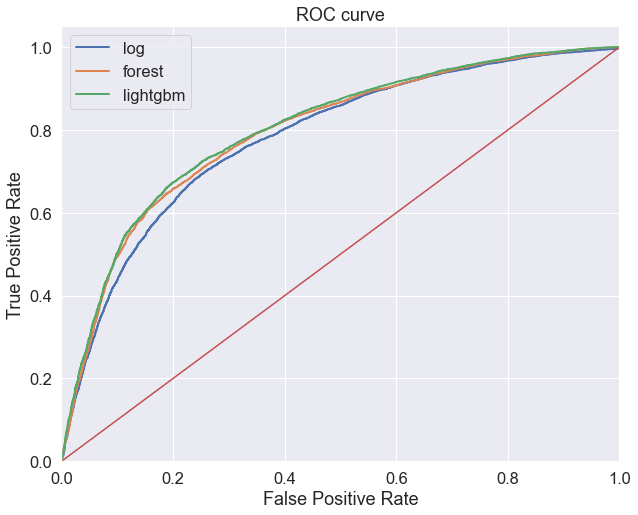

In [147]:
roc_plot(y_test, scores)

In [148]:
metrics

,precision,recall,fscore,roc_auc,log_loss
log,0.644507,0.838825,0.728938,NaN,NaN
random_forest,0.667631,0.824539,0.737835,NaN,NaN
lightgbm,0.660803,0.839631,0.739561,NaN,NaN


In [191]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
score_log = classifier_log.predict_proba(X_test)[:,0]
metrics['roc_auc'].loc['log'] =\
    roc_auc_score(y_true=1-y_test, y_score=score_log)
metrics['log_loss'].loc['log'] =\
    log_loss(y_true=1-y_test, y_pred=classifier_log.predict_proba(X_test)[:,0])

score_random_forest = classifier_random_forest.predict_proba(X_test)[:,0]
metrics['roc_auc'].loc['random_forest'] =\
    roc_auc_score(y_true=1-y_test, y_score=score_random_forest)
metrics['log_loss'].loc['random_forest'] =\
    log_loss(y_true=1-y_test, y_pred=score_random_forest)

score_lightgbm = classifier_lightgbm.predict_proba(X_test)[:,0]
metrics['roc_auc'].loc['lightgbm'] =\
    roc_auc_score(y_true=1-y_test, y_score=score_lightgbm)
metrics['log_loss'].loc['lightgbm'] =\
    log_loss(y_true=1-y_test, y_pred=score_lightgbm)



Посомтрим на матрицу ошибок

In [192]:
metrics

,precision,recall,fscore,roc_auc,log_loss
log,0.644507,0.838825,0.728938,0.781981,0.579303
random_forest,0.667631,0.824539,0.737835,0.795287,0.555957
lightgbm,0.660803,0.839631,0.739561,0.801689,0.540579


In [167]:
from sklearn.metrics import confusion_matrix

In [168]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [184]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 1  # подберем порог для улучшения бизнесс показателя

cnf_matrix_log = confusion_matrix(y_test, score_log>threshold_list[0]*business_threshold)
cnf_matrix_random_forest = confusion_matrix(y_test, score_random_forest\
                                      >threshold_list[1]*business_threshold)
cnf_matrix_ligthgbm = confusion_matrix(y_test, score_lightgbm>threshold_list[2]*business_threshold)

cnf_matrix_log, cnf_matrix_random_forest, cnf_matrix_ligthgbm

(array([[1058, 7762],
        [4240, 4440]]),
 array([[1159, 7661],
        [4886, 3794]]),
 array([[1046, 7774],
        [4806, 3874]]))

Посчитаем FPR, TPR

In [98]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8387096774193549, 0.455328798185941, 0.5446712018140589)

In [190]:
metrics

,precision,recall,fscore,roc_auc,log_loss
log,0.644507,0.838825,0.728938,NaN,NaN
random_forest,0.667631,0.824539,0.737835,NaN,NaN
lightgbm,0.660803,0.839631,0.739561,NaN,NaN


False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[0][1]
 - пропустили больных FN = cnf_matrix[1][0]
 - правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [99]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

Оценим разницу:


In [186]:
def business_threshold_calibrate(y_test, y_score, thresholds,rubl_to_test = 100, rubl_to_early_treatment = 100, rubl_to_late_treatment = 1000):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 

    r2 = []
    n = 20
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        #print(cnf_matrix )
        rubl_1 = ((cnf_matrix[1][1]+cnf_matrix[1][0])) * rubl_to_late_treatment

        rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + ((cnf_matrix[1][0]+cnf_matrix[1][1])) * rubl_to_early_treatment

        rubl_ML = ((cnf_matrix[1][1]+cnf_matrix[0][1])) * rubl_to_test + np.sum(cnf_matrix[1][0]) * rubl_to_late_treatment + (cnf_matrix[1][1]) * rubl_to_early_treatment
       
        r2_r3 = rubl_all_test - rubl_ML 
        
        r1_r2 = rubl_1 - rubl_all_test
        r1_r3 = rubl_1 - rubl_ML
        #print(opt_buisness_tr, r2_r3)
        if (r2_r3_ < r2_r3):
            
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('расходы, если не делать тест и ждать симптомов:',rubl_1_)
    print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test_)
    print('расходы, если не делать тест и ждать симптомов:',rubl_ML_)
    print(' Расходы при решении не делать тесты - расходы с МL :',r1_r3_ )
    print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',r1_r2_ )
    print(' Расходы сделать тесты всем - решение делать тесты ML  :',r2_r3_ )
    plt.plot(np.linspace(0,1,n),r2)
    plt.show()
    return business_threshold
    

In [ ]:
BUisnes_tr = business_threshold_calibrate(y_test, score_log, 
                                          thresholds[0] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[0])
print('Логистическая регрессия')

In [ ]:
BUisnes_tr = business_threshold_calibrate(y_test, score_random_forest, 
                                          thresholds[1] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[1])
print('Случайный лес')

In [ ]:
BUisnes_tr = business_threshold_calibrate(y_test, score_lightgbm, 
                                          thresholds[2] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[2])
print('Lightgbm')

Лучше всего себя показала модель бустинга 

Roc_Auc_curve более устойчива в случае неосбалансированых классов 

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic